# 2D Ising Experiments
The following implements the two-dimensional Ising model with the following parameters: 
- 50x50 lattice
- Initial temperature: 0
- Interaction strength J: 1
- External magnetic field B: 0 

## Equilibration and Correlation Time
Before we can measure any quantities of interest, we need to determine two things:
- Equilibration time: how many sweeps of our MC algorithm are required to come to equilibrium. 
- Correlation time: how many sweeps of our MC algorithm should be made between measurements after equilibration. 

To determine equilibration time, we begin by running our simulation for an arbitrary number of sweeps and observing the behavior of the magnetization and energy values per spin. 

In our first experiment, we run our simulation for 10,000, and then 250, steps per site (hereafter referred to as sweeps). In this simulation, we initialize the lattice to the spin-up ground state corresponding to T=0 and run the simulation at T=5. We then plot the magnetization and energy values per spin.


<img src="figures/50x50_em_v_spin_10000.png" style="display:inline;margin:1px;width: 470px;"/>
<img src="figures/50x50_em_v_spin_250.png" style="display:inline;margin:1px;width: 470px;"/>

The takeaway here is that from T=0 to T=5, the system appears to come to equilibrium on the order of 50 sweeps. In the second experiment, we initialize our lattice to a random configuration (corresponding to infinite T) and cool the system down to T =.001. Again, we plot the magnetization and energy per spin as measured after every sweep. 

<img src="figures/50x50_em_v_spin_1000.png" style="display:inline;margin:1px;width: 470px;"/>
<img src="figures/50x50_em_v_spin_1000_2.png" style="display:inline;margin:1px;width: 470px;"/>
<img src="figures/50x50_em_v_spin_1000_3.png" style="width: 470px;"/>

As we can see from these trials, each of which was performed over 1000 sweeps, the system appears to come to equilibrium after approximately 400 sweeps - although one anomalous trial had an equilibration time of 1000 sweeps. A generous estimation of the time required for equilibration is then on the order of about 1000 sweeps. That is, we expect the vast majority of trials to come to equilibrium after this time. 

Next, we need to determine a correlation length. Once the system has come to equilibrium, approximately how long do we need to wait between measurements.

To evaluate the correlation length, we will attempt to plot the autocorrelation function for magnetization and energy. The autocorrelation function is useful to evaluate because we can infer the correlation length using the relationship

$$\chi(t) \propto e^{-t/\tau}$$

We will evaluate the magnetization autocorrelation function for an initial configuration starting at T=0 and heated to T=2.4. This final temperature choice is significant because it is near the critical temperature and, therefore, we expect the correlation time to approach its maximum near this temperature. The correlation time away from this temperature point will be shorter. 

<img src="figures/50x50_mag_autocorrelation_800_100000.png" style="width: 600px;"/>

From this graph, we can see that the correlation time $\tau$ is roughly 300 sweeps. Therefore, when measuring magnetization after our system has come to equilibrium, we should attempt to sample roughly every $2\tau = 600$ sweeps.   

Below are the results of running the simulation on a $50 \times 50$ lattice from $T=0$ to $T=5$ in $.1$ increments. We plot the magnetization per spin, specific heat, and magnetic susceptibility as a function of temperature. For each temperature point, 1000 equilibration sweeps were performed and measurements were averaged over 1000 sweeps (slightly longer than the indicated correlation time).

<img src="figures/50x50mag_per_spin.png" style="display:inline;margin:1px;width: 470px;"/>
<img src="figures/50x50sh_v_temp_2.png" style="display:inline;margin:1px;width: 470px;"/>
<img src="figures/50x50s_v_temp_2.png" style="width: 550px;"/>

With regard to the deviation in the magnetization graph around the critical temperature, I assume that this is a result of taking the measurements over too short of a time. We expect the correlation time to increase around the critical temperature and therefore the measurements taken may not have been taken properly to reflect the true average. However, the trend is still visible and this problem does not seem to affect the other graphs as drastically.

## Implementation
The Python implementation used to generate these graphs is provided below with comments explaining parameters. 

In [35]:
%matplotlib inline
from random import choice
from numpy import exp, power
from numpy.random import randint, rand
from matplotlib import pyplot, colors
from functools import reduce
from scipy.integrate import simps

class Ising2D(object):
    def __init__(self, rows, columns, init_T = 0, J=1):
        self.rows = rows
        self.columns = columns
        self.lat_size = rows*columns
        self.J = J
        self.initialize(init_T)
        
    def initialize(self, init_T = 0):
        self.sweep_num = 1 # initialize sweep count
        # If T = 0, align all spins to ground state
        if init_T:
            # Assume T large enough to produce random spin state
            self.lattice = [[choice([-1,1]) for i in range(self.columns)] for j in range(self.rows)]
        else:
            # align all spins along +z
            self.lattice = [[1 for i in range(self.columns)] for j in range(self.rows)]
    
    def simulate(self, num_sweeps, T, filename=None):
        self.mag_vals = []
        self.energy_vals = []
        if T == 0:
            T = .001
            
        # Calculate initial magnetization and energy values
        self.mag = self.calc_magnetization()    # initial magnetization
        self.energy =  self.calc_energy() # initial energy
        
        # mag_vals holds the magnetization per spin, calculated every sweep
        # energy_vals holds the total energy, calculated every sweep
        self.mag_vals.append(self.mag/self.lat_size)
        self.energy_vals.append(self.energy)

        for i in range(num_sweeps):
            self.sweep(T)
            
    def calc_energy(self):
        # Calculate the instantaneous energy of the lattice
        # To sum over nearest neighbors and avoid double-counting,
        # we sum over all sites and only calc east and south neighbors.
        energy = 0
        for i in range(self.rows):
            for j in range(self.columns):
                energy += -self.J*self.lattice[i][j]*(self.lattice[i][(j+1)%self.columns] + self.lattice[(i+1)%self.rows][j])
        return float(energy)

    def calc_magnetization(self):
        # Calculate the instantaneous magnetization of the lattice
        mag = 0
        for row in self.lattice:
            for spin in row:
                mag += spin
        return float(mag)
    
    def sweep(self, T):
        # Perform as many steps as there are lattice sites
        for step in range(self.lat_size):
            # Select a new state by randomly choosing a spin to flip
            chosen_site_row = randint(0, self.rows)
            chosen_site_col = randint(0, self.columns)

            # Calculate the difference in energy between new and old state
            # Using the summation trick of Newman, Barkema (equation 3.10)
            delta_E = self.calc_delta_E(chosen_site_row, chosen_site_col)

            if not ((delta_E > 0) and (rand() >= exp(-(1.0/T)*delta_E*self.J))):
                self.lattice[chosen_site_row][chosen_site_col] = self.lattice[chosen_site_row][chosen_site_col]*(-1)
                self.energy = self.energy + delta_E
                self.mag = float(self.mag) + 2*float(self.lattice[chosen_site_row][chosen_site_col])

        self.energy_vals.append(self.energy)
        self.mag_vals.append(self.mag/self.lat_size)
        self.sweep_num += 1
        
    def calc_delta_E(self, row, col):
        # neighbor_sum is sum of nearest neighbor spin values
        neighbor_sum = self.lattice[(row-1)%self.rows][col] # north neighbor
        neighbor_sum += self.lattice[(row+1)%self.rows][col] # south neighbor
        neighbor_sum += self.lattice[row][(col-1)%self.columns] # west neighbor
        neighbor_sum += self.lattice[row][(col+1)%self.columns] # east neighbor
        return 2*self.J*self.lattice[row][col]*neighbor_sum
    
    def plot_mag_energy_per_site(self):
        pyplot.plot([i for i in range(len(self.energy_vals))],[energy/self.lat_size for energy in self.energy_vals], 'r') # plot energy per site
        pyplot.plot([i for i in range(len(self.mag_vals))],self.mag_vals, 'b') # plot magnetization per site
        pyplot.ylabel('Energy (red) and magnetization (blue) per site')
        pyplot.xlabel('Steps per site (i.e. sweeps)')
        pyplot.show()
        
    def autocorrelate_mag(self, sweeps):
        avg_mag = reduce((lambda x,y: x+y), self.mag_vals)/len(self.mag_vals)
        avg_mag_sq = power(avg_mag, 2)

        chi_0 = self.autocorrelate_int(avg_mag_sq, 0) # Initial autocorrelation function chi(0)
        x = [i for i in range(sweeps)]
        y = [self.autocorrelate_int(avg_mag_sq, i, norm=chi_0) for i in range(sweeps)]
        pyplot.plot(x, y, 'b')
        pyplot.ylabel('Magnetization autocorrelation $\chi(t)$')
        pyplot.xlabel('Steps per site')
        pyplot.show()
        
    def autocorrelate_int(self,avg_mag_sq, t, norm = 1):
        # Performs autocorrelation integral at sweep t
        t_prime = [i for i in range(self.sweep_num - t)]
        y_samples = [((self.mag_vals[i]*self.mag_vals[i+t]) - avg_mag_sq)/norm for i in t_prime]
        return simps(y_samples, t_prime)


Making use of the Ising2D involves first creating an instance where the size and initial configuration are specified. Below, we create a 50x50 lattice with an initial temperature of 0 - indicating the initial configuration will be entirely spin-up. Any non-zero temperature will be interpreted as an indication to randomize the initial state.

In [36]:
lat = Ising2D(50, 50, init_T=0)

Performing a simulation can be done directly with the simulate method. The number of sweeps to be performed must be supplied as well as the temperature of the simulation. In the call below, we perform 1000 sweeps at T=5. We then plot the magnetization and energy per site as a function of sweeps performed. In order to re-run the simulation, the lattice must be reset - this can be done by calling the initialize function explicitly (although this is also done during object creation). 

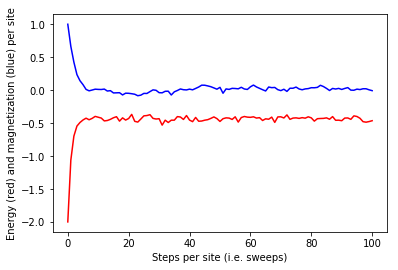

In [31]:
lat.initialize(init_T = 0)
lat.simulate(num_sweeps=100, T=5)
lat.plot_mag_energy_per_site()

To evaluate the autocorrelation function, we call either autocorrelate_mag or autocorrelate_energy after simulation. It is important to make sure that the simulation has been run for significantly longer than the last sweep for which you'd like to calculate the autocorrelation. For example, in the snippet below, we simulate for 50,000 sweeps and then only plot the autocorrelation for the first 800 sweeps. 

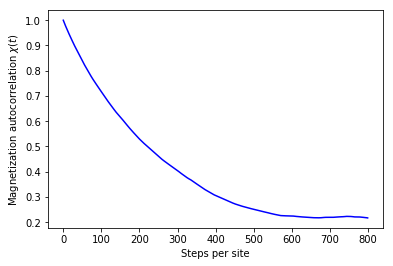

In [37]:
lat.initialize(init_T = 0)
lat.simulate(num_sweeps=50000, T=2.4)
lat.autocorrelate_mag(800)